In [1]:
import numpy as np
import cvxpy as cp
import scipy as sp
from datetime import datetime
import imageio
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import Image

## Simulation Parameters

In [2]:
dt = 0.04  # timestep
t = 3  # duration
m = 1  # mass
q0 = np.array([0, 0, 1])  # init pos
v0 = np.array([10, 0, 20])  # init vel
# force = np.array([0, 30])  # init force
g = 9.8  # gravitational acceleration
# mu = 0.05  # coefficient of friction of the plane
n = np.array([0, 0, 1])  # phi(q) = n @ q

## Simulation Backend

In [3]:
class SimSystem:
    def __init__(self, q0, v0):
        self.q = q0
        self.v = v0
    
    def step_q(self, update=True):
        """ Find next q according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
        
    def step_v(self, update=True):
        """ Find next v according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
    
    def plot(self, q=None):
        """
        Generate a plot for current config (or for Q if specified)
        """
        raise NotImplementedError()
    
    @property
    def dim(self):
        return self.q.shape[0]
        

In [4]:
class Block2DImpact(SimSystem):
    def __init__(self, pos, vel, mass,
                 dt=0.1, solver='ECOS'):
        super().__init__(pos, vel)
        self.m = mass
        self.dt = dt
        self.solver = solver
    
    def step_q(self, update=True):
        q_new = self.q + self.dt * self.v
        if update:
            self.q = q_new
        return q_new
    
    def step_v(self, update=True):
        v = cp.Variable(self.dim)
        constraints = [dt * (n @ v) >= -n @ self.q]
        prob = cp.Problem(cp.Minimize(0.5 * self.m * cp.norm(v, 2)**2 - self.m * v @ self.v + g * self.m * n @ v), constraints)
        prob.solve(solver=self.solver)
        v_new = v.value
        if update:
            self.v = v_new
        return v_new
    
    def plot(self, q=None):
        if q is None:
            q = self.q
        fig = plt.figure()
        canvas = FigureCanvas(fig)
        plt.xlim(-8, 8)
        plt.ylim(-8, 8)
        plt.plot(q[0], q[1], 'ro')
        canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        return img

## Run Simulation

In [5]:
def sim(system, timesteps=10, return_bs=False):
    """
    :param system: (SimSystem) initialized obj representing system,
                    including functions to update q and v
    :param timesteps: (int) number of timesteps to simulate for
    """
    qs, vs = [system.q.copy()], [system.v.copy()]
    t = 0
    while t < timesteps:
        qs.append(system.step_q().copy())
        vs.append(system.step_v().copy())
        t += system.dt
    return np.stack(qs)

In [6]:
system = Block2DImpact(q0, v0, m, dt, solver='ECOS')
qs = sim(system, timesteps=2)

In [7]:
qs

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [4.00000000e-01, 0.00000000e+00, 1.80000000e+00],
       [8.00009854e-01, 0.00000000e+00, 2.20799845e+00],
       [1.20002335e+00, 0.00000000e+00, 2.22400391e+00],
       [1.60003522e+00, 0.00000000e+00, 1.84801072e+00],
       [2.00000739e+00, 0.00000000e+00, 1.08001123e+00],
       [2.40019933e+00, 0.00000000e+00, 1.36251310e-06],
       [2.80039802e+00, 0.00000000e+00, 2.06849702e-10],
       [3.20062313e+00, 0.00000000e+00, 9.03692850e-10],
       [3.60087467e+00, 0.00000000e+00, 9.02476325e-10],
       [4.00115260e+00, 0.00000000e+00, 9.01078789e-10],
       [4.40145692e+00, 0.00000000e+00, 9.00216610e-10],
       [4.80178760e+00, 0.00000000e+00, 8.99326764e-10],
       [5.20214464e+00, 0.00000000e+00, 8.98770090e-10],
       [5.60252801e+00, 0.00000000e+00, 8.96621520e-10],
       [6.00293770e+00, 0.00000000e+00, 8.95904199e-10],
       [6.40337370e+00, 0.00000000e+00, 8.95347980e-10],
       [6.80383597e+00, 0.00000

## Plot

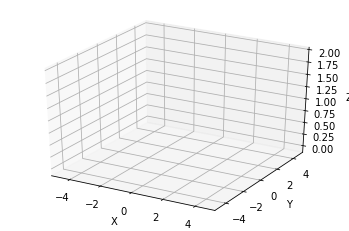

In [10]:
Writer = animation.writers['pillow']
writer = Writer(fps=int(1/dt), bitrate=600)

def update(num, data, line):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])

fig = plt.figure()
ax = fig.gca(projection='3d')
line, = ax.plot(qs[:1, 0], qs[:1, 1], qs[:1, 2])
ax.set_xlim3d([-5, 5])
ax.set_xlabel('X')
ax.set_ylim3d([-5, 5])
ax.set_ylabel('Y')
ax.set_zlim3d([-0.1, 2])
ax.set_zlabel('Z')
ani = animation.FuncAnimation(fig, update, int(t / dt), fargs=(qs.T, line), interval=dt, blit=False)
time = datetime.now().strftime('%m%d%y_%H%M%S')
filename = f'gifs/impact/sim2d_impact_{time}.gif'
ani.save(filename, writer=writer)

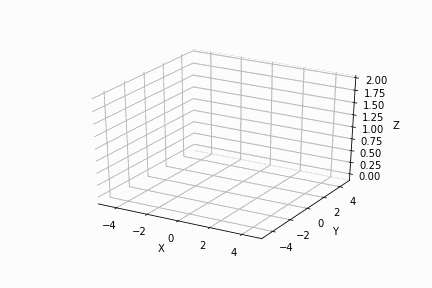

In [11]:
Image(filename=filename)